In [1]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Loading data
data = pd.read_csv('/kaggle/input/human-activity-recognition-with-smartphones/train.csv')
test_data = pd.read_csv('/kaggle/input/human-activity-recognition-with-smartphones/test.csv') 

In [4]:
# Checking the data
print(data.shape, test_data.shape)
print(data.info())

(7352, 563) (2947, 563)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None


In [5]:
data.sample(10)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
1039,0.295583,-0.073432,-0.162099,-0.950396,-0.660883,-0.802191,-0.961309,-0.675294,-0.807218,-0.860680,...,-0.050233,0.020054,0.408013,-0.288220,-0.310064,-0.833915,0.057624,-0.096493,6,SITTING
6425,0.429555,-0.030768,-0.050656,0.069298,0.082567,-0.538511,0.028144,0.014597,-0.539264,0.315044,...,-0.614980,-0.587161,-0.435031,0.939978,-0.657833,-0.742034,0.258188,0.098395,28,WALKING_DOWNSTAIRS
7160,0.123392,-0.074076,0.037349,-0.542771,-0.431087,-0.049954,-0.598099,-0.468914,0.053300,-0.324444,...,-0.902568,0.292484,-0.603229,0.067392,-0.431435,-0.819656,0.219415,0.047794,30,WALKING_UPSTAIRS
5421,0.384588,-0.027402,-0.055920,-0.062718,0.012873,-0.514532,-0.096462,-0.031099,-0.490396,0.331646,...,-0.864702,-0.621322,0.476433,-0.440493,-0.406962,-0.901757,0.134171,-0.043116,25,WALKING_DOWNSTAIRS
6493,0.278621,-0.036262,-0.106593,-0.961760,-0.912001,-0.905920,-0.971368,-0.918829,-0.917133,-0.850917,...,-0.167783,-0.028965,-0.031006,-0.234626,0.018034,-0.674156,0.108012,-0.217762,28,SITTING
4245,0.283402,-0.012401,-0.083052,-0.987000,-0.948316,-0.949232,-0.989892,-0.950088,-0.942662,-0.917769,...,-0.572762,-0.017867,0.043384,0.470312,-0.206799,-0.901784,0.120296,0.085965,21,SITTING
2578,0.276659,-0.017972,-0.109811,-0.997301,-0.996563,-0.991722,-0.997907,-0.996629,-0.992091,-0.941745,...,-0.867270,0.481826,-0.483197,-0.292536,-0.304065,-0.476969,-0.229382,-0.136844,15,SITTING
1563,0.238321,0.002103,-0.049881,-0.337640,0.056347,0.002905,-0.345980,-0.072205,-0.005175,-0.061703,...,-0.539197,0.283744,-0.796913,-0.864676,0.284716,-0.840235,0.208483,0.023272,7,WALKING
2420,0.277595,-0.017792,-0.108561,-0.998053,-0.989590,-0.990203,-0.998596,-0.989101,-0.989901,-0.940575,...,-0.909498,0.067396,0.328908,0.049718,-0.211729,-0.874556,0.035161,-0.048711,14,SITTING
627,0.326145,-0.043925,-0.129278,-0.275163,-0.099460,-0.380906,-0.292921,-0.115754,-0.379459,-0.097328,...,-0.547917,-0.541749,0.698895,0.750461,0.323390,-0.708911,0.262882,0.136065,3,WALKING


In [6]:
# Checking for missing values
missing_values = data.isnull().sum()
column_with_missing_values = missing_values[missing_values > 0]
print(column_with_missing_values)  # There are no missing values

Series([], dtype: int64)


In [7]:
# Checking for duplicated columns
duplicated_columns = data.columns[data.T.duplicated()]
print(duplicated_columns.shape)  # There are duplicated columns 

# Droping duplicated columns
data = data.drop(duplicated_columns, axis=1)
print(data.shape)


(21,)
(7352, 542)


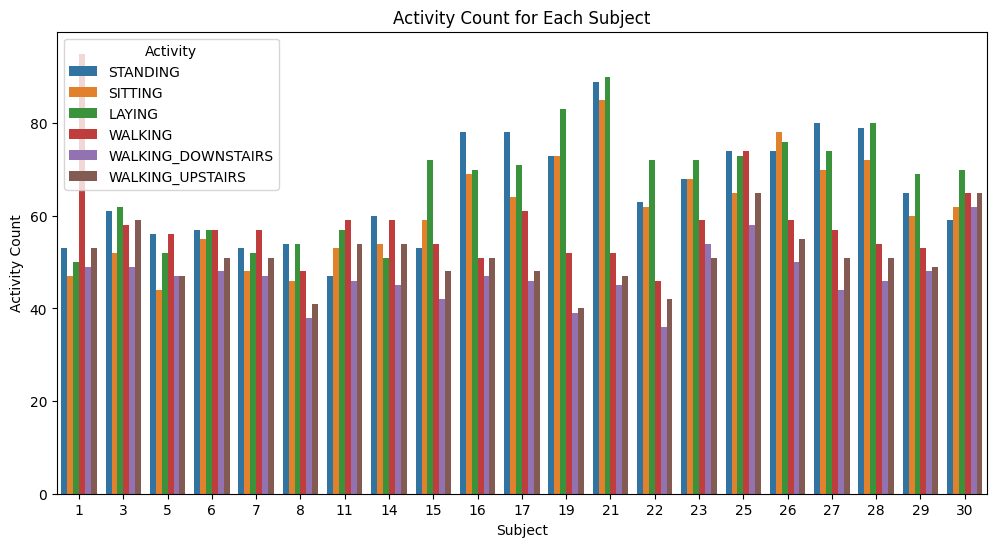

In [8]:
# Plotting the Activity distribution for each subject to check if any subject has more weight
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', hue='Activity', data=data)
plt.title('Activity Count for Each Subject')
plt.xlabel('Subject')
plt.ylabel('Activity Count')
plt.show()

In [9]:
# Preparing features and labels
X = data.drop(['Activity', 'subject'], axis=1)
y = data['Activity']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [10]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Next we will apply feature selection techniques using
# 1- Filter method (correlation analysis, variance threshold)
# 2- Wrapper method (Recursive Feature Elimination)
# Note that Splitting the data before applying feature selection techniques is important to avoid data leakage

In [12]:
# Computing the correlation matrix and remove highly correlated features
correlation_matrix_train = pd.DataFrame(X_train).corr()
mask_train = np.triu(np.ones(correlation_matrix_train.shape), k=1).astype(bool)
correlated_features_train = set()
for i in range(len(correlation_matrix_train.columns)):
    for j in range(i):
        if abs(correlation_matrix_train.iloc[i, j]) > 0.8: #I have experimented with different threshold values (0.7, 0.75)
            colname = correlation_matrix_train.columns[i]
            correlated_features_train.add(colname)
X_train_no_corr = pd.DataFrame(X_train).drop(columns=correlated_features_train)
X_test_no_corr = pd.DataFrame(X_test).drop(columns=correlated_features_train)
print(X_train_no_corr.shape, X_test_no_corr.shape)

(5881, 142) (1471, 142)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


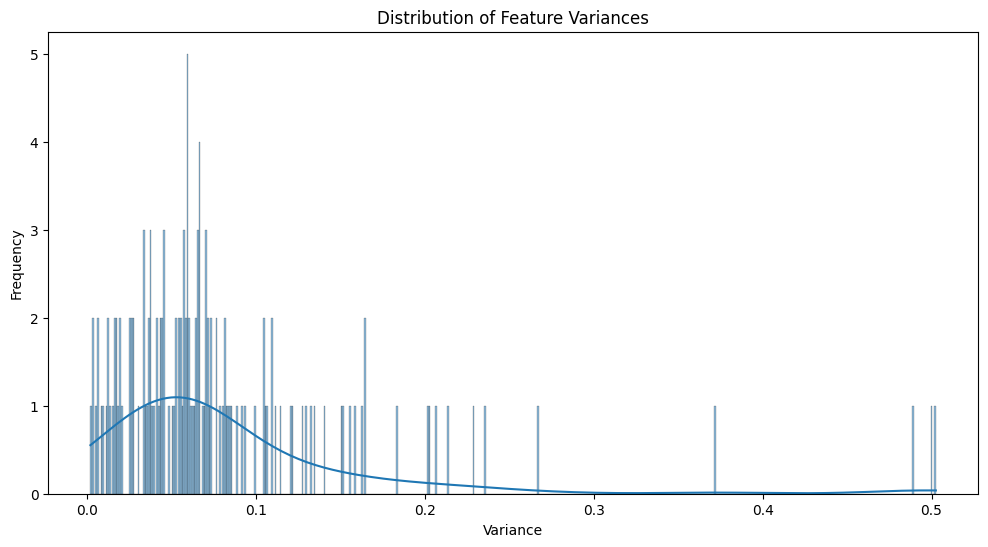

In [13]:
# Features variance analysis
feature_variance = X_train_no_corr.var()
plt.figure(figsize=(12, 6))
sns.histplot(feature_variance, bins=500, kde=True)
plt.title('Distribution of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Variance thresholding
# I have experimented with different threshold values (0.06, 0.08) but 0.04 gave better results
var_selector = VarianceThreshold(threshold=0.04)
X_train_high_variance = var_selector.fit_transform(X_train_no_corr)
X_test_high_variance = var_selector.transform(X_test_no_corr)
print(X_train_high_variance.shape, X_test_high_variance.shape)

(5881, 102) (1471, 102)


In [15]:
# Recursive Feature Elimination (RFE):
# This step is highly sensitive to the number of features to select.
# In my experiments:
# - Selecting 50 features consistently achieved accuracies on unseen data over 94.8%.
# - Experimenting with different numbers of features (22, 30, 40) resulted in accuracies under 94%.
estimator = RandomForestClassifier(random_state=42, n_jobs=-1)
rfe_selector = RFE(estimator, n_features_to_select=50)
X_train_rfe = rfe_selector.fit_transform(X_train_high_variance, y_train)
X_test_rfe = rfe_selector.transform(X_test_high_variance)
print(X_train_rfe.shape)

(5881, 50)


In [16]:
# Experimenting with dimensionality reduction using PCA, but it didn't improve results:
# Results on unseen data: 93.48%

# Uncomment below to apply PCA (not included in final script):
# pca = PCA(n_components=num_components)
# X_train_pca = pca.fit_transform(X_train_rfe)
# X_test_data_pca = pca.transform(X_test_data_rfe)

# Calculate cumulative explained variance:
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components needed to explain 95% variance:
# num_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
# print(f"Number of components to retain 95% variance: {num_components}")

In [17]:
# Defining parameter grids for hyperparameter tuning:
# - After experimenting with GridSearchCV and RandomizedSearchCV,
#   redundant hyperparameters were removed to optimize time and computation.
# - RandomizedSearchCV yielded comparable results to GridSearchCV
#   while significantly reducing time and computational costs.

param_grid_xgb = {
    'classifier__learning_rate': [0.3, 0.4, 0.5],
    'classifier__n_estimators': [50, 100, 150]
}

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [1, 0.1, 0.01],
}

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
}

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_samples_split': [2, 4, 6],
}

In [18]:
# Defining feature scaling for SVM and Logistic Regression
scaler_lr_svc = StandardScaler()
scaler_svc = StandardScaler()

# Initializing THE classifiers
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=6, random_state=42)
svc_model = SVC(probability=True, random_state=42)
lr_model = LogisticRegression(multi_class='auto', random_state=42)
rf_model = RandomForestClassifier(random_state=42)


In [19]:
# Defining pipelines
pipeline_lr = Pipeline([('scaler', scaler_lr_svc), ('classifier', lr_model)])
pipeline_svc = Pipeline([('scaler', scaler_lr_svc), ('classifier', svc_model)])
pipeline_xgb = Pipeline([('classifier', xgb_model)])
pipeline_rf = Pipeline([('classifier', rf_model)])

In [20]:
# Defining RandomizedSearchCV objects
random_search_xgb = RandomizedSearchCV(pipeline_xgb, param_grid_xgb, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search_svc = RandomizedSearchCV(pipeline_svc, param_grid_svc, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search_lr = RandomizedSearchCV(pipeline_lr, param_grid_lr, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search_rf = RandomizedSearchCV(pipeline_rf, param_grid_rf, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

In [21]:
# Fitting RandomizedSearchCV for each classifier
random_search_xgb.fit(X_train_rfe, y_train)
random_search_svc.fit(X_train_rfe, y_train)
random_search_lr.fit(X_train_rfe, y_train)
random_search_rf.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__min_samples_split': [2, 4,
                                                                          6],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42, scoring='accuracy', verbose=2)

In [22]:
# Comparing the best scores of each classifier
best_score_xgb = random_search_xgb.best_score_
best_score_svc = random_search_svc.best_score_
best_score_lr = random_search_lr.best_score_
best_score_rf = random_search_rf.best_score_

print(f"XGBoost Best Score: {best_score_xgb:.4f}")
print(f"SVC Best Score: {best_score_svc:.4f}")
print(f"Logistic Regression Best Score: {best_score_lr:.4f}")
print(f"Random Forest Best Score: {best_score_rf:.4f}")


XGBoost Best Score: 0.9791
SVC Best Score: 0.9697
Logistic Regression Best Score: 0.9476
Random Forest Best Score: 0.9626


In [24]:
# Function to remove 'classifier__' prefix
def remove_classifier_prefix(params):
    return {key.split('__')[1]: value for key, value in params.items()}

# Getting the best parameters for each classifier
best_params_xgb = random_search_xgb.best_params_
best_params_svc = random_search_svc.best_params_
best_params_lr = random_search_lr.best_params_
best_params_rf = random_search_rf.best_params_

# Removing 'classifier__' prefix from best parameters
best_params_xgb = remove_classifier_prefix(best_params_xgb)
best_params_svc = remove_classifier_prefix(best_params_svc)
best_params_lr = remove_classifier_prefix(best_params_lr)
best_params_rf = remove_classifier_prefix(best_params_rf)

print(f"XGBoost Best Parameters: {best_params_xgb}")
print(f"SVC Best Parameters: {best_params_svc}")
print(f"Logistic Regression Best Parameters: {best_params_lr}")
print(f"Random Forest Best Parameters: {best_params_rf}")

XGBoost Best Score: {'n_estimators': 150, 'learning_rate': 0.4}
SVC Best Score: {'gamma': 0.01, 'C': 10}
Logistic Regression Best Score: {'C': 1}
Random Forest Best Score: {'n_estimators': 300, 'min_samples_split': 2}
[CV] END classifier__learning_rate=0.3, classifier__n_estimators=50; total time=   2.9s
[CV] END classifier__learning_rate=0.3, classifier__n_estimators=50; total time=   2.8s
[CV] END classifier__learning_rate=0.3, classifier__n_estimators=100; total time=   4.2s
[CV] END classifier__learning_rate=0.3, classifier__n_estimators=150; total time=   5.9s
[CV] END classifier__learning_rate=0.4, classifier__n_estimators=50; total time=   2.6s
[CV] END classifier__learning_rate=0.4, classifier__n_estimators=100; total time=   3.5s
[CV] END classifier__learning_rate=0.4, classifier__n_estimators=150; total time=   4.3s
[CV] END classifier__learning_rate=0.4, classifier__n_estimators=150; total time=   4.4s
[CV] END classifier__learning_rate=0.5, classifier__n_estimators=100; tot

In [25]:
# Initializing THE classifiers with THEIR best parameters
xgb_model_best = xgb.XGBClassifier(**best_params_xgb)
svc_model_best = SVC(**best_params_svc, probability=True)
lr_model_best = LogisticRegression(**best_params_lr, multi_class='auto')
rf_model_best = RandomForestClassifier(**best_params_rf)


In [26]:
# Voting Classifier initialization:
# - Experimented with different weight configurations:
# - Both of these configurations yielded the best results.
#   1. Equal weights for all classifiers.
#   2. Highest weight for XGBoost (xgb), lowest for Logistic Regression,
#      and equal weights for SVM and Random Forest.
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model_best),
        ('svc', svc_model_best),
        ('lr', lr_model_best),
        ('rf', rf_model_best)
    ],
    voting='soft',
    weights=[2.2, 2, 1.6, 1.8]
)
voting_clf.fit(X_train_rfe, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=150, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('svc', SVC(C=10, gamma=0.01, probability=True)),
                             ('lr', LogisticRegression(C=1)),
                             ('rf', RandomForestClassifier(n_estimators=300))],
                 voting='soft', weights=[2.2, 2, 1.6, 1.8])

In [27]:
# Evaluating Voting Classifier
y_pred_voting = voting_clf.predict(X_test_rfe)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
conf_matrix_voting = confusion_matrix(y_test, y_pred_voting)
class_report_voting = classification_report(y_test, y_pred_voting)

print(f"Test Accuracy: {accuracy_voting:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_voting)
print("\nClassification Report:")
print(class_report_voting)


Test Accuracy: 0.9735

Confusion Matrix:
[[280   0   0   0   0   0]
 [  0 245  17   0   0   0]
 [  0  13 263   0   0   0]
 [  0   0   0 245   0   2]
 [  0   0   0   0 203   3]
 [  0   0   0   0   4 196]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       280
           1       0.95      0.94      0.94       262
           2       0.94      0.95      0.95       276
           3       1.00      0.99      1.00       247
           4       0.98      0.99      0.98       206
           5       0.98      0.98      0.98       200

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



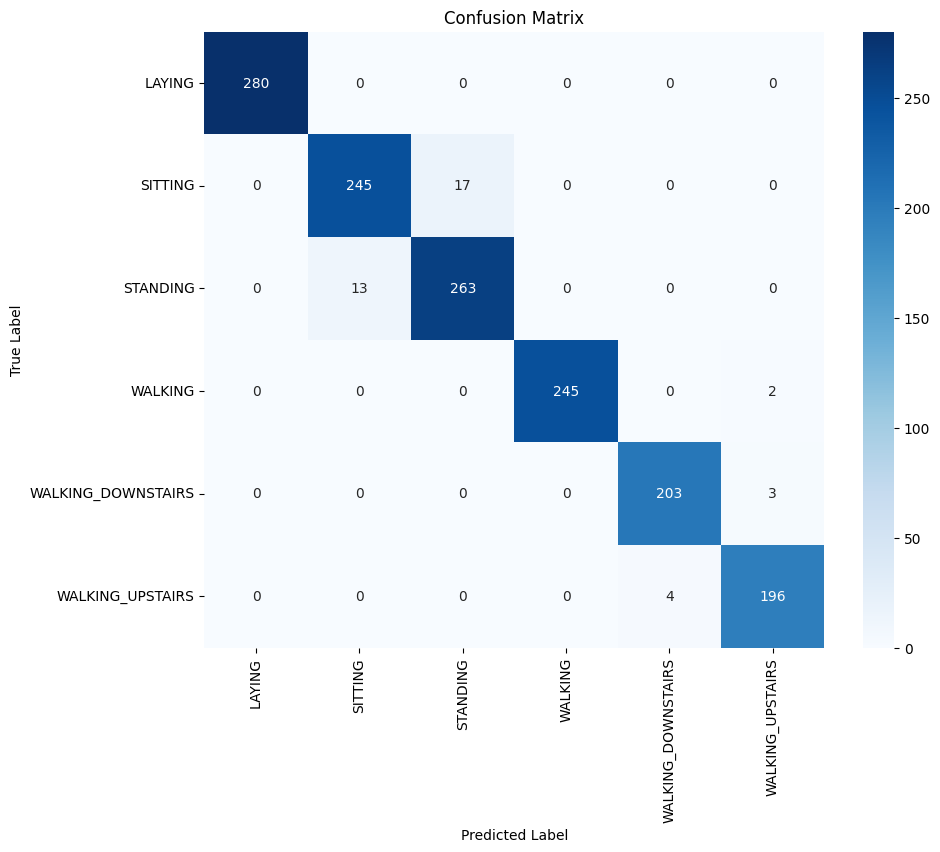

In [28]:
# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_voting, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Decoding the  predictions
decoded_predictions = label_encoder.inverse_transform(y_pred_voting)

#Original and decoded labels comparison
print("\nOriginal Labels:")
print(y_test[:10])
print("\nDecoded Labels:")
print(decoded_predictions[:10])


Original Labels:
[4 4 3 1 4 3 5 3 4 2]

Decoded Labels:
['WALKING_DOWNSTAIRS' 'WALKING_DOWNSTAIRS' 'WALKING' 'SITTING'
 'WALKING_DOWNSTAIRS' 'WALKING' 'WALKING_UPSTAIRS' 'WALKING'
 'WALKING_DOWNSTAIRS' 'STANDING']


In [30]:
# Evaluating the model on unseen data
# Preprocessing the unseen data
test_data = test_data.drop(duplicated_columns, axis=1)
print(test_data.shape)

X_test_data = test_data.drop(['Activity', 'subject'], axis=1)
y_test_data = test_data['Activity']
y_test_data = label_encoder.transform(y_test_data)

(2947, 542)


In [31]:
X_test_data_no_corr = pd.DataFrame(X_test_data).drop(columns=correlated_features_train)
print(X_test_data_no_corr.shape)

X_test_data_high_variance = var_selector.transform(X_test_data_no_corr)
X_test_data_rfe = rfe_selector.transform(X_test_data_high_variance)

y_pred_test = voting_clf.predict(X_test_data_rfe)
decoded_predictions_test = label_encoder.inverse_transform(y_pred_test)

(2947, 142)


In [32]:
# Evaluation metrics
accuracy_test = accuracy_score(y_test_data, y_pred_test)
conf_matrix_test = confusion_matrix(y_test_data, y_pred_test)
class_report_test = classification_report(y_test_data, y_pred_test)
print(f"Accuracy on Test Data: {accuracy_test:.4f}")
print("\nConfusion Matrix on Test Data:")
print(conf_matrix_test)
print("\nClassification Report on Test Data:")
print(class_report_test)

Accuracy on Test Data: 0.9505

Confusion Matrix on Test Data:
[[537   0   0   0   0   0]
 [  0 446  42   0   0   3]
 [  0  32 500   0   0   0]
 [  0   0   0 493   3   0]
 [  0   0   0   8 386  26]
 [  0   0   0  22  10 439]]

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.93      0.91      0.92       491
           2       0.92      0.94      0.93       532
           3       0.94      0.99      0.97       496
           4       0.97      0.92      0.94       420
           5       0.94      0.93      0.94       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947

